# Fraud detection demo

The goal of this demo is to showcase how Memgraph can be used to load table data from different sources like parquet files stored in local or external file systems. This is a step-by-step showcase of Memgraph ecosystem. The demo is split into different topics:

##### 1.  Storing row-based format into Memgraph
Such row-based formats are SQL tables, Parquet data frames, as well as CSV, ORC and Feather files. Therefore, these row-based records can be transformed into graph via suitable transformations to nodes and relationships. To accomplish that, GQLAlchemy offers a solution in a form of defining a configuration for loading each table.

##### 2.  Exploring the dataset by using GQLAchemy querying
With simple queries, information can be gathered by using GQLAlchemy. Fetching these elements enables user to get more insight into different parts of dataset and to create queries which offer a human way of interacting with frauds. For example, gathering all fraud individuals that share an address will lead towards new suspects.

##### 3.  Extracting graph features from the dataset
Graph algorithms are suitable for use cases such as fraud detection because of the amplification of relationships within the dataset entities. Community detection, PageRank and Node2Vec are just a few of those that we will use to showcase abilities of Memgraph MAGE to extract useful information from graph data. 

##### 4.  Preparing and running the prediction model based on extracted features
Furthermore in the pipeline, once we have extracted features, we can simply run a prediction model on top of them. This enables to adapt to changes and once new data is created, use the model to predict on history information.


## Prerequisites

For this tutorial, you will need to install:

- [Jupyter](https://jupyter.org/install): Jupyter is needed if you want to run this tutorial as a notebook.
- [Docker](https://docs.docker.com/get-docker/): Docker is used because Memgraph is a native Linux application and cannot be installed on Windows and macOS.
- [GQLAlchemy](https://pypi.org/project/gqlalchemy/): A Python OGM (Object Graph Mapper) that connects to Memgraph
- other Python packages from `pyproject.toml`. You can install them with `poetry install`.

#### Installation using Docker

After you install Docker, you can set up Memgraph by running:

```
docker run -it -p 7687:7687 -p 3000:3000 memgraph/memgraph-platform
```

This command will start the download and after it finishes, run the Memgraph container.

#### Connect to Memgraph with GQLAlchemy

In [23]:
# Import the library needed for graph data handling
# GQLAlchemy is the Object Graph Mapper (OGM) - a link between graph database objects and Python objects.
import gqlalchemy

# Import key features from GQLAlchemy
from gqlalchemy import Memgraph, QueryBuilder
from gqlalchemy.loaders import ParquetLocalFileSystemImporter

# Import environment config and file handlers
from dotenv import load_dotenv
from pathlib import Path
import os
import yaml

In [24]:
# Load configuration from environment file
load_dotenv(".env")

True

In [25]:
# Define a graph DB connector
mg_host = os.getenv("MG_HOST", "localhost")
mg_port = int(os.getenv("MG_PORT", "7687"))
db = Memgraph(mg_host, mg_port)

 ### 1. Storing row-based format into Memgraph

To use the mock dataset run the `data_generator` script. Parameters are `<TOTAL_FAMILIES>` and `<TOTAL_INCIDENTS>`.

In [4]:
!python dataset/data_generator.py 1000 300

Data generation started...
Data stored in dataset/data !


Now, define a mapping between Tables and Nodes/Relationships - nodes are graph entities that are
connected with relationships. We can define them on table-like format and insert them from any
row-based storage such are SQL table, parquet dataframes, CSV files, etc. The only thing neded is 
defining mapping between these entities.

In [10]:
PATH_TO_CONFIG_YAML = "./config.yml"

with Path(PATH_TO_CONFIG_YAML).open("r") as f_:
    data_configuration = yaml.safe_load(f_)

translator = ParquetLocalFileSystemImporter(
    path="./dataset/data/",
    data_configuration=data_configuration
)

# Ensure that Memgraph is in clean state once we start out loading
translator.translate(drop_database_on_start=True)

Created index for ADDRESS on add_id
Created index for INDIVIDUAL on ind_id
Created index for VEHICLE on veh_id
Created index for POLICY on pol_id
Created index for CLAIM on clm_id
Created index for INCIDENT on inc_id
Created index for CLAIM_PAYMENT on pay_id
Created index for INJURY on inj_id
Created trigger INDIVIDUAL__add_id__ADDRESS__add_id
Created trigger ADDRESS__add_id__INDIVIDUAL__add_id
Created trigger POLICY__insurer_id__INDIVIDUAL__ind_id
Created trigger INDIVIDUAL__ind_id__POLICY__insurer_id
Created trigger POLICY__insured_with_id__INDIVIDUAL__ind_id
Created trigger INDIVIDUAL__ind_id__POLICY__insured_with_id
Created trigger POLICY__veh_id__VEHICLE__veh_id
Created trigger VEHICLE__veh_id__POLICY__veh_id
Created trigger POLICY__add_id__ADDRESS__add_id
Created trigger ADDRESS__add_id__POLICY__add_id
Created trigger CLAIM__inc_id__INCIDENT__inc_id
Created trigger INCIDENT__inc_id__CLAIM__inc_id
Created trigger INCIDENT__pol_id__POLICY__pol_id
Created trigger POLICY__pol_id__INC

![](img/demo.png)

### 3. Exploring the dataset by using GQLAchemy querying

Now, when we have everything settled, we are able to explore the data from Memgraph DB.
Querying should be fairly simple, using the GQLAlchemy or openCypher query language.

Here is the example of fetching policies from some individuals

In [26]:
query_builder = QueryBuilder(db)
results = list(
    query_builder.match() # Match different entities
    .node("POLICY", variable="policy") # Match policies
    .to("INSURED") # With relationship INSURED
    .node("INDIVIDUAL", variable="insurer") # To an individual
    .return_() # Return all the variables
    .limit(5) # Limit the output to 5 elements
    .execute()
)

# Log the output for each of the resulting rows
for result in results:
    insurer = result["insurer"]
    policy = result["policy"]
    
    print(f"{insurer.first_name} {insurer.last_name} "
          f"is insured with POLICY: "
          f"{{valid_from: {policy.start_date}, valid_to: {policy.end_date}, policy_type: { policy.type}}}")

Katherine Richard is insured with POLICY: {valid_from: 2022-02-19, valid_to: 2022-09-09, policy_type: MEDICAL}
John Richard is insured with POLICY: {valid_from: 2022-08-28, valid_to: 2024-06-02, policy_type: MEDICAL}
Jorge Richard is insured with POLICY: {valid_from: 2022-06-02, valid_to: 2023-06-02, policy_type: MEDICAL}
Jacqueline Poole is insured with POLICY: {valid_from: 2021-05-27, valid_to: 2022-11-02, policy_type: COLLISION}
Jacqueline Poole is insured with POLICY: {valid_from: 2020-10-12, valid_to: 2021-12-04, policy_type: COMPREHENSIVE}


Let's say we are curious about getting the individual with largest number of policies
This time, we will write a raw openCypher query for larger flexibility

In [27]:

results = db.execute_and_fetch("""
    MATCH (insurer:INDIVIDUAL)<-[:INSURED]-(policy:POLICY)
    RETURN insurer, count(policy) AS num_policies
    ORDER BY num_policies DESC
    LIMIT 5;
""")

# Log the output for each of the resulting rows
for result in results:
    insurer = result["insurer"]
    num_policies = result["num_policies"]
    
    print(f"{insurer.first_name} {insurer.last_name} has {num_policies} policies.")

Erica Gomez has 6 policies.
Lindsey Martinez has 6 policies.
Stephanie Quinn has 5 policies.
Janet Glass has 5 policies.
Jodi Martinez has 4 policies.


Moving into the interest area of potential frauds,
here we list some fraudulent claims and their associates

In [28]:
results = db.execute_and_fetch("""
    MATCH (individual:INDIVIDUAL)<-[:INSURED]-(policy:POLICY)<-[]-(incident:INCIDENT)<-[]-(fraud:CLAIM {fraud: True})
    RETURN individual, fraud
    LIMIT 5;
""")

# Log the output for each of the resulting rows
for result in results:
    insurer = result["individual"]
    fraudulent_claim = result["fraud"]
    
    print(f"{insurer.first_name} {insurer.last_name} was involved in claim {fraudulent_claim.clm_id} which was marked as fraud.")

Christopher Flores was involved in claim 982a6d40 which was marked as fraud.
Jesse Hodges was involved in claim f0a097e6 which was marked as fraud.
Christina Hart was involved in claim c01da58d which was marked as fraud.
Taylor Flores was involved in claim ac0e5ed5 which was marked as fraud.
Mary Nguyen was involved in claim 3818a6da which was marked as fraud.


After obtaining frauds in history, we would like to extract features for each of them, and encorporate
them to detect the new fraud. 

First, we need to simulate out feature store. For these purposes, we'll use Pandas, frequent DataFrame format
Let's define some features

In [11]:
import pandas as pd
class FeatureStore:
    IND_COUNT = "ind_count"
    AMT_PAID = "amount_paid"
    POL_EXPIRED = "policy_expired"
    POL_PREMIUM = "policy_premium"
    INFLUENCE = "influence"
    NUM_FRAUDS_NEIGHBORHOOD = "num_frauds_neighborhood"
    NUM_FRAUDS_COMMUNITY = "num_frauds_community"
    EMBEDDING = "embedding"
    FRAUD = 'fraud'
    
    
FEATURE_NAMES = [
    FeatureStore.IND_COUNT, 
    FeatureStore.AMT_PAID, 
    FeatureStore.POL_EXPIRED, 
    FeatureStore.POL_PREMIUM, 
    FeatureStore.INFLUENCE, 
    FeatureStore.NUM_FRAUDS_NEIGHBORHOOD, 
    FeatureStore.NUM_FRAUDS_COMMUNITY, 
    FeatureStore.EMBEDDING, 
    FeatureStore.FRAUD, 
]

First, define simple feature types

In [12]:
from datetime import datetime, date

# Count of individuals related to the incident/claim could be
# useful information when combined with other features.
def get_individual_count(claim_id: str) -> int:
    return next(db.execute_and_fetch(f"""
        MATCH (claim:CLAIM {{clm_id: '{claim_id}'}})-[]->(incident:INCIDENT)-[]->(individual:INDIVIDUAL)
        RETURN COUNT(individual) AS {FeatureStore.IND_COUNT}
    """))[FeatureStore.IND_COUNT]


# Price paid for the claim can be a fine indicator of whether there
# is a suspicious activity going on.
def get_amount_paid(claim_id: str) -> float:
    amt_paid =  next(db.execute_and_fetch(f"""
        MATCH (claim:CLAIM {{clm_id: '{claim_id}'}})<-[]-(payment:CLAIM_PAYMENT)
        RETURN SUM(payment.amount) AS {FeatureStore.AMT_PAID}
    """))[FeatureStore.AMT_PAID]
    
    return amt_paid if amt_paid else 0


# Filing a claim on expired policy might be a bad sign
def get_policy_expired(claim_id: str) -> bool:
    today = str(datetime.now().date())
    return next(db.execute_and_fetch(f"""
        MATCH (claim:CLAIM {{clm_id: '{claim_id}'}})-[]->(:INCIDENT)-[]->(policy:POLICY)
        RETURN  policy.end_date < date('{today}') AS {FeatureStore.POL_EXPIRED}
    """))[FeatureStore.POL_EXPIRED]


# Depending on premium level, the amount covered can vary, suspicion too.
def get_policy_premium(claim_id: str) -> bool:
    premium = next(db.execute_and_fetch(f"""
        MATCH (claim:CLAIM {{clm_id: '{claim_id}'}})-[]->(:INCIDENT)-[]->(policy:POLICY)
        RETURN  policy.premium AS {FeatureStore.POL_PREMIUM} 
    """))[FeatureStore.POL_PREMIUM]
    return premium if premium else "U"

Choose one claim id and set it as a variable to be used in these examples:

In [29]:
test_claim_id = "982a6d40"

In [30]:
print("Number of individuals involved: ", get_individual_count(test_claim_id))
print("Total amount paid: ", get_amount_paid(test_claim_id))
print("Is policy expired: ", get_policy_expired(test_claim_id))
print("Policy premium type: ", get_policy_premium(test_claim_id))

Number of individuals involved:  3
Total amount paid:  7175.7
Is policy expired:  False
Policy premium type:  U


### 4.  Extracting graph features from the dataset

It's time to apply some graph analytics on our fraud model

After splitting the graph entities into communities, communities with individuals
related to previous frauds will have larger probability of being fraudulent

In [31]:
def run_community_detection() -> None:
    db.execute(f"""
        CALL community_detection_online.set() YIELD node, community_id
        SET node.community = community_id;
    """)

# Measure of centrality can help 
def run_pagerank() -> None:
    db.execute(f"""
        CALL pagerank_online.set(100, 0.2) YIELD node, rank
        SET node.influence = rank;
    """)


# These are highly artificial vectors of numbers, but they encode a graph structure.
# Malicious groups act alike, therefore their structural encodings will be the same.
def run_node_embedding() -> None:
    db.execute(f"""
        CALL node2vec.set_embeddings() YIELD *;
    """)

run_community_detection()
run_pagerank()
run_node_embedding()

In [34]:
def get_num_frauds_community(claim_id: str) -> float:
    return next(db.execute_and_fetch(f"""
        MATCH (claim:CLAIM {{clm_id: '{claim_id}'}}), (fraud:CLAIM {{fraud: True}})
        WHERE claim.community = fraud.community
        RETURN COUNT(fraud) AS {FeatureStore.NUM_FRAUDS_COMMUNITY}
    """))[FeatureStore.NUM_FRAUDS_COMMUNITY]

def get_num_frauds_neighborhood(claim_id: str) -> float:
    return next(db.execute_and_fetch(f"""
        MATCH (claim:CLAIM {{clm_id: '{claim_id}'}})-[*bfs ..4]-(fraud:CLAIM {{fraud: True}})
        RETURN COUNT(fraud) AS {FeatureStore.NUM_FRAUDS_NEIGHBORHOOD}
    """))[FeatureStore.NUM_FRAUDS_NEIGHBORHOOD]

def get_influence(claim_id: str) -> float:
    return next(db.execute_and_fetch(f"""
        MATCH (claim:CLAIM {{clm_id: '{claim_id}'}})
        RETURN claim.influence AS {FeatureStore.INFLUENCE}
    """))[FeatureStore.INFLUENCE]

def get_embedding(claim_id: str) -> float:
    return next(db.execute_and_fetch(f"""
        MATCH (claim:CLAIM {{clm_id: '{claim_id}'}})
        RETURN claim.embedding AS {FeatureStore.EMBEDDING}
    """))[FeatureStore.EMBEDDING]

print("Number of frauds in community: ", get_num_frauds_community(test_claim_id))
print("Number of close/related frauds: ", get_num_frauds_neighborhood(test_claim_id))
print("Claim influence: ", get_influence(test_claim_id))
print()
print("Claim vector embedding", get_embedding(test_claim_id))

Number of frauds in community:  1
Number of close/related frauds:  0
Claim influence:  0.00010544430735411197

Claim vector embedding [0.09475097805261612, 0.2893894910812378, 0.10628315061330795, -0.18005914986133575, 0.08311939984560013, -0.1795181781053543, -0.0664520263671875, 0.01584327034652233, 0.11893633753061295, -0.15397332608699799, -0.1455812156200409, -0.2777945101261139, 0.06764007359743118, 0.14838582277297974, -0.019456954672932625, -0.08026906847953796, -0.18999165296554565, -0.28295910358428955, 0.06002788990736008, 0.0555458627641201, 0.1072806864976883, -0.05415064096450806, 0.02410547249019146, -0.021786928176879883, 0.15650144219398499, -0.24369214475154877, 0.11819690465927124, 0.03465935215353966, -0.05355159565806389, -0.20859570801258087, -0.016595518216490746, 0.04156307503581047, -0.16977497935295105, -0.14370673894882202, 0.1429239958524704, -0.14620448648929596, 0.08028645813465118, -0.15954887866973877, 0.059030674397945404, -0.10856687277555466, 0.128615

Generate all features for each possible claim

In [43]:
import pandas as pd

def get_claims():
    return db.execute_and_fetch(f"""
        MATCH (claim:CLAIM)
        RETURN claim
    """)

CLAIM_ID = 'claim_id'
feature_store = pd.DataFrame(columns = FEATURE_NAMES + [CLAIM_ID])


# Store the claims into feature store - a dataframe
for i, result in enumerate(get_claims()):
    claim = result['claim']
    claim_features = {
        FeatureStore.IND_COUNT: get_individual_count(claim.clm_id),
        FeatureStore.AMT_PAID: get_amount_paid(claim.clm_id),
        FeatureStore.POL_EXPIRED: get_policy_expired(claim.clm_id),
        FeatureStore.POL_PREMIUM: get_policy_premium(claim.clm_id),
        FeatureStore.NUM_FRAUDS_COMMUNITY: get_num_frauds_community(claim.clm_id),
        FeatureStore.NUM_FRAUDS_NEIGHBORHOOD: get_num_frauds_neighborhood(claim.clm_id),
        FeatureStore.INFLUENCE: get_influence(claim.clm_id),
        FeatureStore.EMBEDDING: [get_embedding(claim.clm_id)],
        FeatureStore.FRAUD: claim.fraud,
        CLAIM_ID: claim.clm_id
    }
    feature_store = pd.concat([feature_store, pd.DataFrame(claim_features)], ignore_index=True)

feature_store = feature_store.set_index(CLAIM_ID)

/home/mg/Workspace/code/memgraph/insurance-fraud/ve3/lib/python3.10/site-packages/gqlalchemy/models.py:321: GQLAlchemySubclassNotFoundWarning: ({'CLAIM'}, <class 'gqlalchemy.models.Node'>)
  warnings.warn(GQLAlchemySubclassNotFoundWarning(types, cls))


StopIteration: 

### 5.  Preparing and running the prediction model based on extracted features

<AxesSubplot:xlabel='Predicted', ylabel='Actual'>

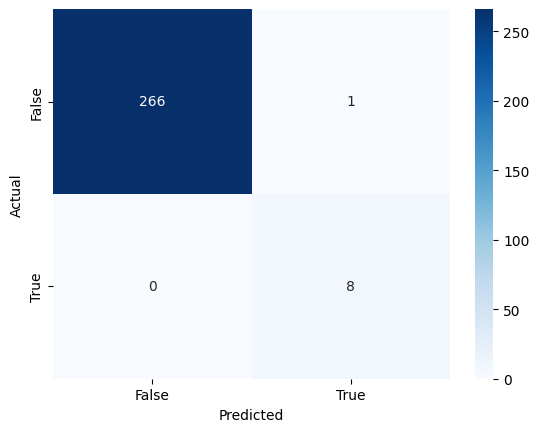

In [39]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.utils import resample
from sklearn import metrics
import seaborn as sn
import matplotlib.pyplot as plt


# Extracting the features for training phase out of feature store
X = feature_store[[
    FeatureStore.IND_COUNT, 
    FeatureStore.AMT_PAID, 
    FeatureStore.NUM_FRAUDS_COMMUNITY,
    FeatureStore.POL_PREMIUM,
    FeatureStore.NUM_FRAUDS_NEIGHBORHOOD,
    FeatureStore.INFLUENCE,
]]
# Selecting the feature type. 
X = X.astype({
    FeatureStore.IND_COUNT: int,
    FeatureStore.AMT_PAID: float,
    FeatureStore.NUM_FRAUDS_COMMUNITY: int,
    FeatureStore.POL_PREMIUM: "category",
    FeatureStore.NUM_FRAUDS_NEIGHBORHOOD: int,
    FeatureStore.INFLUENCE: float,
})

# If feature is categorical, encode them in one-hot encoding scheme
dummies = pd.get_dummies(X[FeatureStore.POL_PREMIUM], prefix=FeatureStore.POL_PREMIUM)
X = X.join(dummies)
X = X.drop(columns=[FeatureStore.POL_PREMIUM])
y = feature_store[FeatureStore.FRAUD]
y = y.astype({
    FeatureStore.FRAUD: bool,
})
feature_columns = X.columns

# Split the dataset into training and testing
# NOTE: In real-life scenario, this split will be time-dependent
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=0)

# Upsample the minority class data
train_data = pd.concat((X_train, y_train), axis=1)
X_positive = train_data[train_data[FeatureStore.FRAUD] == True]
X_negative = train_data[train_data[FeatureStore.FRAUD] == False]

X_positive = resample(X_positive, 
                      replace=True,    
                      n_samples=len(X_negative) // 2)
train_data = pd.concat((X_positive, X_negative), axis=0)

y_train = train_data[FeatureStore.FRAUD]
X_train = train_data.drop(columns=[FeatureStore.FRAUD])

# Fit the simplest logistic regression model by using scikit-learn 
logistic_regression= LogisticRegression()
logistic_regression.fit(X_train,y_train)
y_pred=logistic_regression.predict(X_test)

# Draw a confusion matrix and discuss the results. Here, the results are
# correlated to the dataset which is not highly accurate.
confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])
sn.heatmap(
    confusion_matrix, 
    annot=True,
    fmt='g',
    cmap='Blues'
)

In [40]:
# To enable faster processing, Memgraph offers a dynamic analytics. Once data is inserted, analytics
# is calculated on the fly. To set it, we create triggers.

def create_community_detection_trigger():
    db.execute("""
        CREATE TRIGGER community_detection_online_trigger BEFORE COMMIT
        EXECUTE CALL community_detection_online.update(createdVertices, createdEdges, updatedVertices, updatedEdges, deletedVertices, deletedEdges) YIELD node, community_id
        SET node.community = community_id;
    """)

def create_influence_trigger():
    db.execute("""
        CREATE TRIGGER influence_trigger BEFORE COMMIT
        EXECUTE CALL pagerank_online.update(createdVertices, createdEdges, deletedVertices, deletedEdges) YIELD *
        SET node.influence = rank;
    """)
    
create_community_detection_trigger()
create_influence_trigger()

In [41]:
# Now let's create another item in the database
# We'll simulate how items are inserted into SQL DB

NEW_CLAIM_ID = 'bc7462cb'

INCIDENT_ID = 'bf418431'
ADDRESS_ID = '4700feb8'
POLICY_ID = 'b74bf655'
CLAIM2_ID = 'e93ffa1a'
INJURY_ID = 'abde1883'
INDIVIDUAL_ID = '7324cb18'
PAYMENT_ID = 'bd384ce3'
PAYEE_ID = '35d27b82'

# Create INCIDENT in table
def create_incident(incident_id, policy_id, address_id):
    date = str(datetime.now())
    db.execute(f"""
    CREATE (:INCIDENT {{
        accident_date: "{date}",
        add_id: "{address_id}",
        file_date: "{date}",
        inc_id: "{incident_id}",
        pol_id: "{policy_id}" 
    }});
    """)

def create_incident_individual(incident_id, individual_id):
    db.execute(f"""
    MATCH (a:INCIDENT {{inc_id: "{incident_id}"}}) 
    MATCH (b:INDIVIDUAL {{ind_id: "{individual_id}"}})
    CREATE (a)-[:INCIDENT]->(b);
    """)

# Create claims
def create_claim(claim_id, incident_id, amount):
    db.execute(f"""
    CREATE (:CLAIM {{
            clm_id: "{claim_id}",
            inc_id: "{incident_id}",
            amount: "{amount}"
    }});
    """)

# Create injuries
def create_injury(injury_id, injury_type, claim_id, individual_id):
    db.execute(f"""
    CREATE (:INJURY {{
            clm_id: "{claim_id}",
            ind_id: "",
            inj_id: "{injury_id}",
            type: "{injury_type}"
    }});
    """)

# Create payment
def create_payment(payment_id, amount, claim_id, payer_id, payee_id):
    db.execute(f"""
    CREATE (:CLAIM_PAYMENT {{
        amount: {amount},
        clm_id: "{claim_id}",
        pay_id: "{payment_id}",
        payee_id: "{payee_id}",
        payer_id: "{payer_id}"
    }});
    """)

create_incident(INCIDENT_ID, POLICY_ID, ADDRESS_ID)
create_incident_individual(INCIDENT_ID, INDIVIDUAL_ID)
create_incident_individual(INCIDENT_ID, PAYEE_ID)

create_claim(NEW_CLAIM_ID, INCIDENT_ID, 4313)
create_claim(CLAIM2_ID, INCIDENT_ID, 2500)
create_injury(INJURY_ID, "Legs", NEW_CLAIM_ID, INDIVIDUAL_ID)
create_payment(PAYMENT_ID, 4300, NEW_CLAIM_ID, INDIVIDUAL_ID, PAYEE_ID)

In [42]:
def extract_features(clm_id, columns):
    X = pd.DataFrame({
        FeatureStore.IND_COUNT: get_individual_count(clm_id),
        FeatureStore.AMT_PAID: get_amount_paid(clm_id),
        FeatureStore.NUM_FRAUDS_COMMUNITY: get_num_frauds_community(clm_id),
        FeatureStore.NUM_FRAUDS_NEIGHBORHOOD: get_num_frauds_neighborhood(clm_id),
        FeatureStore.INFLUENCE: get_influence(clm_id),
    }, index=[clm_id])
    # Selecting the feature type. 
    X = X.astype({
        FeatureStore.IND_COUNT: int,
        FeatureStore.AMT_PAID: float,
        FeatureStore.NUM_FRAUDS_COMMUNITY: int,
        FeatureStore.NUM_FRAUDS_NEIGHBORHOOD: int,
        FeatureStore.INFLUENCE: float,
    })
    X = pd.get_dummies(X)
    X = X.reindex(columns = columns, fill_value=0)
    return X

print(feature_columns)
print(NEW_CLAIM_ID)
new_features = extract_features(NEW_CLAIM_ID, feature_columns)
y_pred=logistic_regression.predict(new_features)
print(f"Claim {NEW_CLAIM_ID} fraud prediction: {y_pred}")
new_features

Index(['ind_count', 'amount_paid', 'num_frauds_community',
       'num_frauds_neighborhood', 'influence', 'policy_premium_A',
       'policy_premium_B', 'policy_premium_C', 'policy_premium_D',
       'policy_premium_U'],
      dtype='object')
bc7462cb
Claim bc7462cb fraud prediction: [False]


,ind_count,amount_paid,num_frauds_community,num_frauds_neighborhood,influence,policy_premium_A,policy_premium_B,policy_premium_C,policy_premium_D,policy_premium_U
bc7462cb,0,4300.0,0,0,0.000172,0,0,0,0,0
